In [6]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable                     Type              Data/Info
--------------------------------------------------------
fullOrder                    int               80
hatMathcalPext               LinearIOSystem    <LinearIOSystem>: sys[2]\<...> [0. 0.]\n     [0. 0.]]\n
hsvMathcalPext               ndarray           80: 80 elems, type `float64`, 640 bytes
mathcalEext                  LinearICSystem    <LinearICSystem>: sys[3]\<...> [0. 0.]\n     [0. 0.]]\n
mathcalP                     LinearIOSystem    <LinearIOSystem>: sys[6]\<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPext                  LinearIOSystem    <LinearIOSystem>: sys[8]\<...> [0. 0.]\n     [0. 0.]]\n
normExtMathcalEext_MIMO      ndarray           3x2: 6 elems, type `float64`, 48 bytes
normInfExtMathcalEext        float64           0.02978814489716295
normInfHatMathcalPext        float64           0.4401105950014766
normInfHatMathcalPext_MIMO   ndarray           3x2: 6 elems, type `float64`, 48 bytes
normInfMathcalP              flo

In [7]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

<IPython.core.display.Math object>

TransferFunction(array([0.08 , 0.008]), array([  1., 100.]))

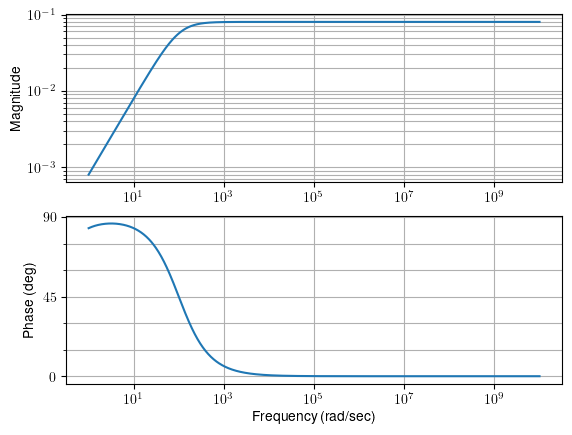

In [8]:
# Create 2nd order low-pass filter
Kp = 80e-6
Td = 10e0
N = 1.0e3

# num =  [ (Kp/Td) * N * (N + Td), (Kp/Td) * N * (1.0/Td) ]
# den = [ 1, N/Td ]
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]

mathcalC = control.tf2ss(num,den)
display(Math('\\mathcal{C} = '), control.ss2tf(mathcalC))

# Plot freq response
wLims = numpy.array([1e0, 1e10])
control.bode_plot(mathcalC, omega_limits=wLims, deg=True, wrap_phase=True)
plt.show()

<IPython.core.display.Math object>

TransferFunction(array([ 0.08, -0.08]), array([1., 0.]), 0.75)

<IPython.core.display.Math object>

TransferFunction(array([-8.]), array([  1., 100.]))

<IPython.core.display.Math object>

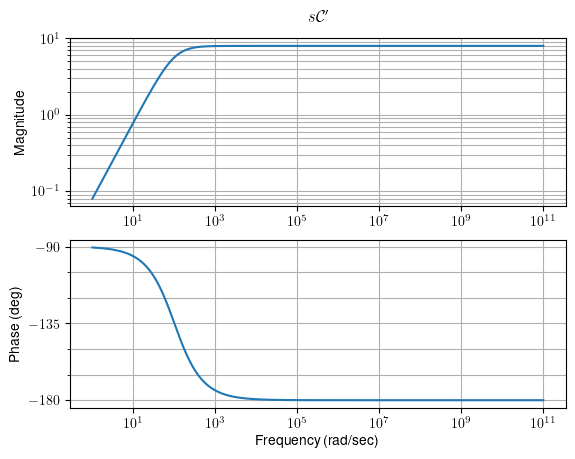

In [9]:
# Discretizing Controller
Tsam = 750.0e-3
overlineMathcalC = control.tf2ss(control.sample_system(control.ss2tf(mathcalC), Tsam, 'zoh'))
display(Math('\\overline{\\mathcal{C}} = '), control.ss2tf(overlineMathcalC))
# display(Math('eigs(\\overline{A_c}) = '), sympy.Matrix(numpy.linalg.eigvals(overlineMathcalC.A)))

# Creating mathcalCPrime and cumputing norm of tildeMathcalC
mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
tfMathcalCPrime = control.ss2tf(mathcalCPrime)
display(Math('\\mathcal{C}^{\\prime} = '), tfMathcalCPrime)

# Inf norm of Delta operator
normInfDelta = 2*Tsam/numpy.pi
s = control.TransferFunction.s
# Norm widetildeMathcalC s
normInfWidetildeMathcalCs = normInfDelta * ControlUtils.hinfnorm(mathcalC)[0] \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime)[0] * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime)[0] * normInfDelta 
display(Math('\\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' + str(normInfWidetildeMathcalCs)))

wLims = numpy.array([10e-1, 10e10])
# print(control.zeros(s*tfMathcalCPrime))
# print(control.poles(s*tfMathcalCPrime))
control.bode_plot(s*tfMathcalCPrime, omega_limits=wLims, deg=True, wrap_phase=True)
plt.title( '$s\\mathcal{C}^{\\prime}$', y=2.25 )
plt.show()

In [10]:
# Creating closed-loop

# Controller matrices
Ac = mathcalC.A
Bv = mathcalC.B
Cw = mathcalC.C
Dw = mathcalC.D

#######################################################################

# FOM extended plant
Ap = mathcalPext.A
Bw = mathcalPext.B[:,0:1]
Bu = mathcalPext.B[:,1:2]
Cv = mathcalPext.C[0:1,:]
Cy = mathcalPext.C[-1:,:]
Dv = mathcalPext.D[0:1,:]
Dy = mathcalPext.D[-1:,:]
# Closed-loop with FOM Extended Plant
Acl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                            numpy.column_stack( [ Bv@Cv, Ac ] )
                            ] )
Bcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                            numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                            ] )
Ccl = numpy.row_stack( [ # numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                            numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                            numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                            ] )
Dcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                            numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                            numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                            ] )
mathcalPcl = control.ss(Acl,Bcl,Ccl,Dcl)
normInfMathcalPcl, normInfMathcalPcl_MIMO = ControlUtils.hinfnorm( mathcalPcl )

# L2 gain
display(Math('\\lVert \\mathcal{P}_{cl}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfMathcalPcl)))

# Small-gain condition
display(Math('\\lVert \\mathcal{P}_{cl}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
    + str(normInfMathcalPcl*normInfWidetildeMathcalCs) ))

#######################################################################

# Closed-loop with ROM Extended Plant
hatAp_ext = hatMathcalPext.A
hatBw_ext = hatMathcalPext.B[:,0:1]
hatBu_ext = hatMathcalPext.B[:,1:2]
hatCv_ext = hatMathcalPext.C[0:1,:]
hatCy_ext = hatMathcalPext.C[-1:,:]
hatDv_ext = hatMathcalPext.D[0:1,:]
hatDy_ext = hatMathcalPext.D[-1:,:]
hatAcl = numpy.row_stack( [ numpy.column_stack( [ hatAp_ext + hatBw_ext@Dw@hatCv_ext, hatBw_ext@Cw ] ),
                            numpy.column_stack( [ Bv@hatCv_ext, Ac ] )
                            ] )
hatBcl = numpy.row_stack( [ numpy.column_stack([hatBw_ext, hatBu_ext]),
                            numpy.column_stack( [ numpy.zeros( (Ac.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (Ac.shape[0],hatBu_ext.shape[1]) ) ] )
                            ] )
hatCcl = numpy.row_stack( [ # numpy.column_stack( [ hatCv_ext, numpy.zeros( (hatCv_ext.shape[0],Ac.shape[0]) ) ] ),
                            numpy.column_stack( [ hatCv_ext@hatAp_ext + hatCv_ext@hatBw_ext@Dw@hatCv_ext, hatCv_ext@hatBw_ext@Cw ] ),
                            numpy.column_stack( [ hatCy_ext, numpy.zeros( (hatCy_ext.shape[0],Ac.shape[0]) ) ] )
                            ] )
hatDcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (hatCv_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCv_ext.shape[0],hatBu_ext.shape[1]) ) ] ),
                            numpy.column_stack( [ hatCv_ext@hatBw_ext , hatCv_ext@hatBu_ext] ),
                            numpy.column_stack( [ numpy.zeros( (hatCy_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCy_ext.shape[0],hatBu_ext.shape[1]) ) ] )
                            ] )
hatMathcalPcl = control.ss(hatAcl,hatBcl,hatCcl,hatDcl)
normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO = ControlUtils.hinfnorm( hatMathcalPcl )

# L2 gain
display(Math('\\lVert \\widehat{\\mathcal{P}}_{cl}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfHatMathcalPcl)))

# Small-gain condition
display(Math('\\lVert \\widehat{\\mathcal{P}}_{cl}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
    + str(normInfHatMathcalPcl*normInfWidetildeMathcalCs) ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
%store -d mathcalC overlineMathcalC Tsam mathcalPcl normInfMathcalPcl normInfMathcalPcl_MIMO hatMathcalPcl normInfHatMathcalPcl normInfHatMathcalPcl_MIMO
%store mathcalC overlineMathcalC Tsam mathcalPcl normInfMathcalPcl normInfMathcalPcl_MIMO hatMathcalPcl normInfHatMathcalPcl normInfHatMathcalPcl_MIMO

Stored 'mathcalC' (StateSpace)
Stored 'overlineMathcalC' (StateSpace)
Stored 'Tsam' (float)
Stored 'mathcalPcl' (LinearIOSystem)
Stored 'normInfMathcalPcl' (float64)
Stored 'normInfMathcalPcl_MIMO' (ndarray)
Stored 'hatMathcalPcl' (LinearIOSystem)
Stored 'normInfHatMathcalPcl' (float64)
Stored 'normInfHatMathcalPcl_MIMO' (ndarray)
